In [70]:
import numpy as np
import matplotlib.pyplot as plt
import time
import IPython.display
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor, LongTensor
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable as V
from torch.nn import functional as F
print(torch.__version__)

0.4.1


the number of data point(original signal): 44100


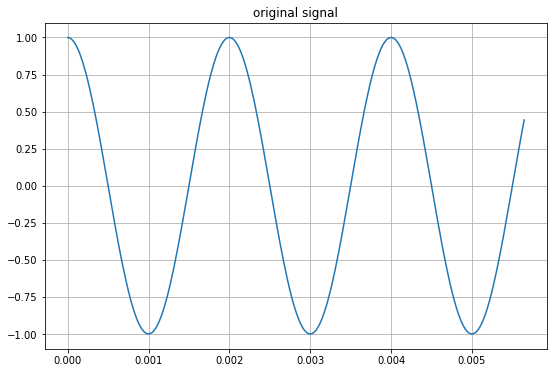

In [2]:
# 学習に使う人工データの生成
sampling_rate = 44100.0 # サンプリング周波数 [Hz] 
len_seconds = 1.0 # 時間長さ[s]
f_original = 500 # 原信号の周波数
t = np.arange(sampling_rate * len_seconds) / sampling_rate # サンプリング点の時間[s]
original_signal = np.cos(2 * np.pi *  f_original * t) # cosで原信号の生成
print('the number of data point(original signal):', len(original_signal))

# 原信号の描画
%matplotlib inline
plt.figure(figsize = (9, 6))
plt.plot(t[:250], original_signal[:250])
plt.title('original signal')
plt.grid()
plt.show()

# 原信号の再生
IPython.display.Audio(original_signal, rate=44100)

In [3]:
# ①FM変調
# f_carrierは搬送波の周波数[Hz]、MFDは最大周波数偏移[Hz]
# 参考文献 : http://yyatsuo.com/?p=1635
def freq_mod(original_signal, f_original, f_carrier, MFD):
    vm = np.sin(2*np.pi*f_carrier*t + (MFD/f_original)*np.sin(2*np.pi*f_original*t))
    return vm

the number of data point(frequency modulation signal): 44100


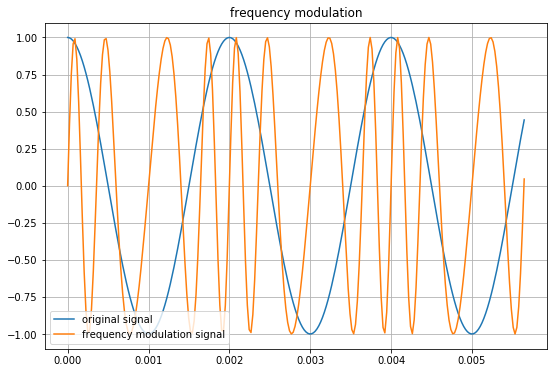

In [4]:
# 搬送波の周波数2000 [Hz], 最大周波数偏移 1000 [Hz] (一般的でない値？)
fm_signal = freq_mod(original_signal, f_original, 2000, 1000)
print('the number of data point(frequency modulation signal):', len(fm_signal))
plt.figure(figsize = (9, 6))
plt.plot(t[:250], original_signal[:250], label = 'original signal')
plt.plot(t[:250], fm_signal[:250], label = 'frequency modulation signal')
plt.legend(loc = 'lower left')
plt.title('frequency modulation')
plt.grid()
plt.show()

#FM変調信号の再生
IPython.display.Audio(fm_signal, rate=44100)

In [5]:
# ②AM変調
# f_carrierは搬送波の周波数 [Hz]
def amp_mod(original_signal, f_original, f_carrier):
    vm = np.cos(2*np.pi*f_carrier*t) + (1/2) * (np.cos(2*np.pi*(f_carrier-f_original)*t)+np.cos(2*np.pi*(f_carrier-f_original)*t))
    return vm

the number of data point(amplitude modulation signal): 44100


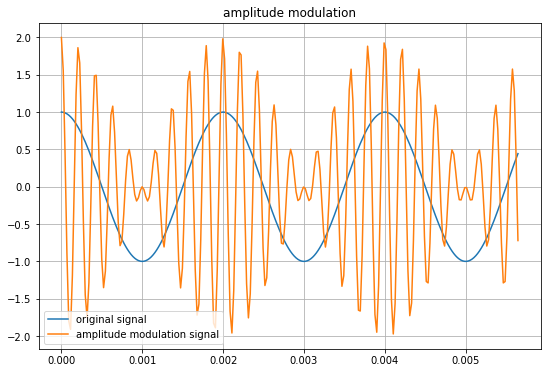

In [6]:
# 搬送波の周波数5000 [Hz] （一般的でない値？）
am_signal = amp_mod(original_signal, f_original, 5000)
print('the number of data point(amplitude modulation signal):', len(am_signal))
plt.figure(figsize = (9, 6))
plt.plot(t[:250], original_signal[:250], label = 'original signal')
plt.plot(t[:250], am_signal[:250], label = 'amplitude modulation signal')
plt.legend(loc = 'lower left')
plt.title('amplitude modulation')
plt.grid()
plt.show()

# AM変調信号の再生
IPython.display.Audio(am_signal, rate=44100)

In [7]:
# 信号の量子化（符号あり16bit）
def quantize_16bit(signal):
    signal = signal - np.mean(signal)
    quantized_16bit_signal = (signal / np.max(np.abs(signal))*(2**15)).astype(np.int16)
    return quantized_16bit_signal

In [8]:
# 信号の量子化（符号なし8bit）
def quantize_8bit(signal):
    signal = signal - np.mean(signal)
    signal = signal / np.max(np.abs(signal))
    signal = np.round(signal * (2 ** 7 - 1))
    signal = (signal + 127).astype(np.uint8)
    return signal

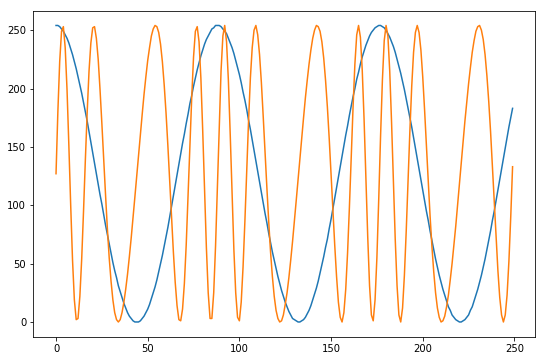

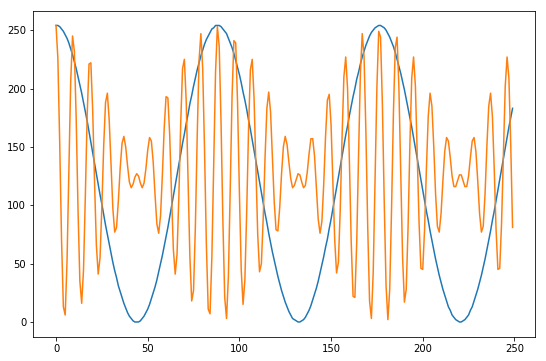

In [9]:
# 取り敢えず0 ～ 255の分類問題にするために量子化（なんか0 ～　254になってしまっている？）
# 原論文では符号あり16bitに量子化された音声データをμ-lawアルゴリズムで8ビット化しているようだが、取り敢えず今回は直接符号なし8ビットに
original_signal_quantized_8bit = quantize_8bit(original_signal)
fm_signal_quantized_8bit = quantize_8bit(fm_signal)
am_signal_quantized_8bit = quantize_8bit(am_signal)
plt.figure(figsize = (9, 6))
plt.plot(original_signal_quantized_8bit[:250])
plt.plot(fm_signal_quantized_8bit[:250])
plt.show()
plt.figure(figsize = (9, 6))
plt.plot(original_signal_quantized_8bit[:250])
plt.plot(am_signal_quantized_8bit[:250])
plt.show()

In [213]:
# 受容野の広さと信号を受け取り、それに応じたデータセットを作成
# ”受容野の広さ”数分の信号のクラスを入力データ、次の瞬間の信号1つのクラスを出力データとする
N_reception = 8
def make_dataset(signal, n_reception):
    X = []
    Y = []
    for i in range(len(signal) - n_reception):
        X.append(signal[i:i+n_reception])
        Y.append(signal[i+n_reception])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [214]:
# FM変調信号学習、バリデーションのためのデータセットの準備
X_fm, Y_fm = make_dataset(fm_signal_quantized_8bit, N_reception)
X_fm_train, X_fm_valid, Y_fm_train, Y_fm_valid = train_test_split(X_fm, Y_fm, test_size = 0.2)
ds_fm_train = TensorDataset(Tensor(X_fm_train), LongTensor(Y_fm_train))
ds_fm_valid = TensorDataset(Tensor(X_fm_valid), LongTensor(Y_fm_valid))
fm_train_loader = DataLoader(ds_fm_train, batch_size = 64, shuffle = True)
fm_valid_loader = DataLoader(ds_fm_valid, batch_size = 64, shuffle = False)

In [215]:
# AM変調信号学習、バリデーションのためのデータセットの準備
X_am, Y_am = make_dataset(am_signal_quantized_8bit, N_reception)
X_am_train, X_am_valid, Y_am_train, Y_am_valid = train_test_split(X_am, Y_am, test_size = 0.2)
ds_am_train = TensorDataset(Tensor(X_am_train), LongTensor(Y_am_train))
ds_am_valid = TensorDataset(Tensor(X_am_valid), LongTensor(Y_am_valid))
am_train_loader = DataLoader(ds_am_train, batch_size = 64, shuffle = True)
am_valid_loader = DataLoader(ds_am_valid, batch_size = 64, shuffle = False)

In [216]:
# 単なる多層パーセプトロン
class MLP(nn.Module):
    def __init__(self, n_reception, hidden_size, n_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_reception, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, n_classes)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        return out

In [217]:
# CNN

In [218]:
# dilated convolution
class Dilated_Conv1D(nn.Module):
    def __init__(self, n_reception, n_classes):
        super(Dilated_Conv1D, self).__init__()
        self.cv1 = nn.Conv1D()

In [219]:
# ロス関数、オプティマイザ
net = MLP(N_reception, 128, 256)
params = list(net.parameters())
N_params = 0
for p in params:
    N_params += len(p)
print('the number of parameters:', N_params)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01)

the number of parameters: 1024


In [220]:
def train(train_loader):
    net.train()
    running_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = V(inputs)
        targets = V(targets)
        
        preds = net(inputs)
        loss = loss_fn(preds, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / (i + 1)
    
    return train_loss

In [221]:
def valid(valid_loader):
    net.eval()
    running_loss = 0
    for i, (inputs, targets) in enumerate(valid_loader):
        inputs = V(inputs)
        targets = V(targets)
        
        preds = net(inputs)
        loss = loss_fn(preds, targets)
        
        running_loss += loss.data.item()
    
    valid_loss = running_loss / (i + 1)
    
    return valid_loss

In [222]:
losses = []
val_losses = []
n_epoch = 10
start = time.time()
for epoch in range(n_epoch):
    loss = train(fm_train_loader)
    val_loss = valid(fm_valid_loader)
    print('epoch[%d/%d] loss:%1.4f val_loss:%1.4f elasped_time:%4.4f' % (epoch+1, n_epoch, loss, val_loss, time.time() - start))
    
    losses.append(loss)
    val_losses.append(val_loss)
print('elasped_time:%2.4f' % (time.time() - start))

epoch[1/10] loss:3.8209 val_loss:3.0093 elasped_time:3.4645
epoch[2/10] loss:2.8900 val_loss:2.6806 elasped_time:8.5525
epoch[3/10] loss:2.6222 val_loss:2.6688 elasped_time:13.8174
epoch[4/10] loss:2.5113 val_loss:2.4353 elasped_time:18.8121
epoch[5/10] loss:2.3377 val_loss:2.4678 elasped_time:24.5000
epoch[6/10] loss:2.2682 val_loss:2.4366 elasped_time:30.0630
epoch[7/10] loss:2.1957 val_loss:2.1554 elasped_time:35.4766
epoch[8/10] loss:2.1759 val_loss:2.4930 elasped_time:41.8416
epoch[9/10] loss:2.1488 val_loss:2.2870 elasped_time:48.2299
epoch[10/10] loss:2.1094 val_loss:2.1955 elasped_time:54.6842
elasped_time:54.6842


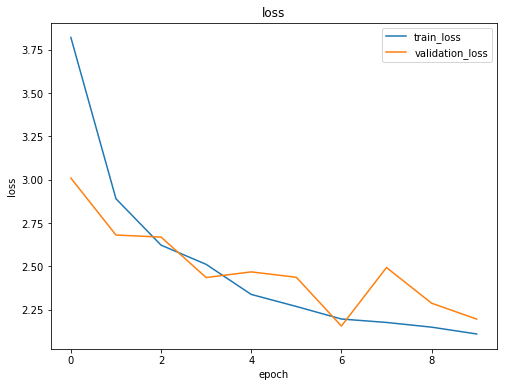

In [223]:
plt.figure(figsize = (8,6))
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses, label = 'train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.legend()
plt.show()

In [224]:
s_point = 20
n_predict_point = 1000
data_first = fm_signal_quantized_8bit[s_point : s_point + N_reception]
data_for_pred = np.copy(data_first)
predicted_data = []
for i in range(n_predict_point):
    output = net(V(Tensor(data_for_pred)))
    _, pred = torch.max(output, 0) 
    pred = pred.item()
    predicted_data.append(pred)
    data_for_pred = np.append(data_for_pred, pred)
    data_for_pred = np.delete(data_for_pred, 0)
predicted_data = np.concatenate([data_first, predicted_data])

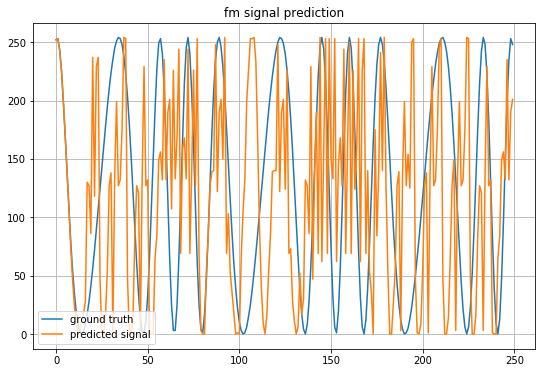

In [225]:
s_plot = 0
plt.figure(figsize = (9, 6))
plt.plot(fm_signal_quantized_8bit[s_plot + s_point : s_plot + s_point + 250], label = 'ground truth')
plt.plot(predicted_data[s_plot:s_plot + 250], label = 'predicted signal')
plt.legend(loc = 'lower left')
plt.title('fm signal prediction')
plt.grid()
plt.show()